In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from datetime import datetime, timedelta


In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model

Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/7z/5v8cn40x2k701p5sng7ywpj80000gn/T/ipykernel_17937/2813101324.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [38]:
# View all of the classes that automap found
#for class_name in Base.classes.keys():

print(Base.classes.keys())

['measurement', 'station']


In [39]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date


'2017-08-23'

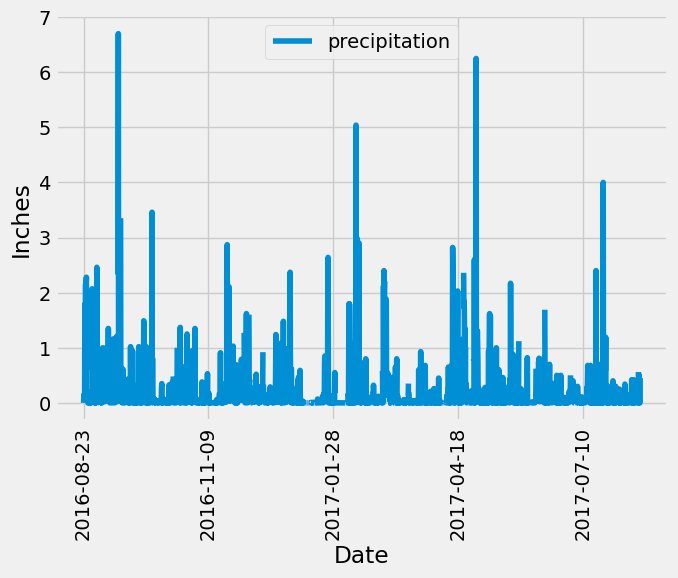

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_str = pd.to_datetime(most_recent_date).strftime("%Y-%m-%d")
most_recent_date = datetime.strptime(most_recent_date_str,'%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_sort = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sort.plot(x='date', y='precipitation', kind='line', figsize=(7,6), legend=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = station_Measurment_join[0][0]
results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==active_station_id).all()

results_temp


[(54.0, 85.0, 71.66378066378067)]

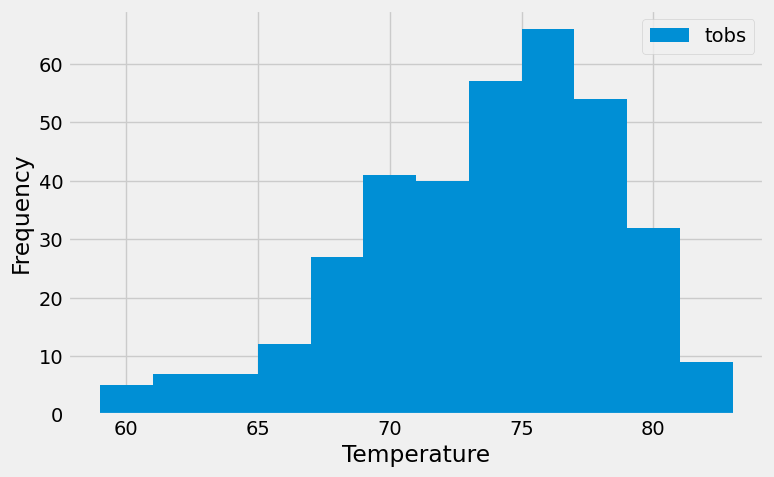

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==station_Measurment_join[0][0]).\
             filter(Measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), zorder=2, legend=True)

hist.set_ylabel("Frequency")
hist.set_xlabel("Temperature")

plt.show()

# Close Session

In [48]:
# Close Session
session.close()